In [1397]:
import pandas as pd
import numpy as np
import category_encoders as ce
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

rng = np.random.RandomState(42)

import warnings
warnings.filterwarnings("ignore")

In [1423]:
rtrain = pd.read_csv('m_race_hist.csv')

In [1424]:
itrain = pd.read_csv('m_horse_info.csv')

In [1425]:
rtrain['Pla.'] = rtrain['Pla.'].replace(['WV', 'WV-A', 'WX-A', 'UR', 'DISQ', 'WXNR', 'PU',
                        'WX', 'TNP', np.nan], 999)

In [1426]:
rtrain.drop(rtrain[rtrain['Pla.'] == 999].index, inplace = True)

In [1427]:
train = rtrain.join(itrain.set_index('hname'), on='hname')

In [1404]:
target = train['Pla.']

In [1405]:
train.drop('Pla.', axis = 1, inplace = True)

In [1408]:
target = target.astype(int)

In [1409]:
target = target.where(target > 3, 1)

In [1410]:
target = target.where(target <= 3, 0)

In [1411]:
target.value_counts()

0    11718
1     4581
Name: Pla., dtype: int64

In [1428]:
train.sample(5)

,Act. Wt.,Date,Declar. Horse Wt.,Dist.,Dr,G,Gear,Jockey,LBW,Pla.,...,Dam's Sire,Import Type,No. of starts in past 10 race meetings,Owner,Sire,Start of Season Rating,Colour,Sex,Country_of_Origin,Age
8327,131,16/06/18,1118.0,1200,8.0,GF,B,N Callan,6-3/4,07,...,Foreplay,PPG,1,Thing On Group Syndicate,Denman,49.0,Brown,Gelding,AUS,5
7551,125,16/05/18,1037.0,1650,1.0,GF,B-,T Berry,2-1/2,05,...,Keeper,PP,1,Ko Kam Piu,Tavistock,37.0,Bay,Gelding,NZ,8
7451,133,27/12/15,1085.0,1400,11.0,G,XB/TT,G Benoist,1,03,...,Sadler's Wells,PP,2,Tai Woon Shing & Timon Tai,Oasis Dream,39.0,Bay,Gelding,IRE,9
8328,133,27/05/18,1118.0,1200,12.0,GF,B,N Callan,3-1/2,07,...,Foreplay,PPG,1,Thing On Group Syndicate,Denman,49.0,Brown,Gelding,AUS,5
9120,121,25/11/18,1004.0,1400,5.0,G,B,S de Sousa,3/4,02,...,Cullen,PPG,0,Chan Ming Wing,Rip Van Winkle,55.0,Bay,Gelding,NZ,5


In [1412]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16299 entries, 0 to 16590
Data columns (total 30 columns):
Act.  Wt.                                  16299 non-null int64
Date                                       16299 non-null object
Declar.  Horse Wt.                         16292 non-null float64
Dist.                                      16299 non-null int64
Dr                                         16299 non-null float64
G                                          16299 non-null object
Gear                                       12383 non-null object
Jockey                                     16299 non-null object
LBW                                        16299 non-null object
Race  Class                                16299 non-null object
Race  Index                                16299 non-null object
Rtg.                                       16221 non-null float64
Trainer                                    16299 non-null object
hname                                      16

In [1413]:
cate = [c for c in train.columns.tolist() if c not in ['Act.  Wt.',
                                'Declar.  Horse Wt.', 
                                'Dist.','Dr',
                                'Rtg.', 'Current Rating',
                                'No. of starts in past 10  race meetings',
                                'Start of  Season Rating', 'Age']]

In [1414]:
ce_target_encoder = ce.TargetEncoder(cols = cate, smoothing=.3)
ce_target_encoder.fit(train, target)

TargetEncoder(cols=['Date', 'G', 'Gear', 'Jockey', 'LBW', 'Race  Class',
                    'Race  Index', 'Trainer', 'hname', 'RC', 'Track', 'Course',
                    'U_raceno', 'Dam', "Dam's Sire", 'Import Type', 'Owner',
                    'Sire', 'Colour', 'Sex', 'Country_of_Origin'],
              drop_invariant=False, handle_missing='value',
              handle_unknown='value', min_samples_leaf=1, return_df=True,
              smoothing=0.3, verbose=0)

In [1415]:
train = ce_target_encoder.transform(train)

In [1416]:
train.drop('Date', axis = 1, inplace = True)
train.drop('LBW', axis = 1, inplace = True)
train.drop('Race  Index', axis = 1, inplace = True)

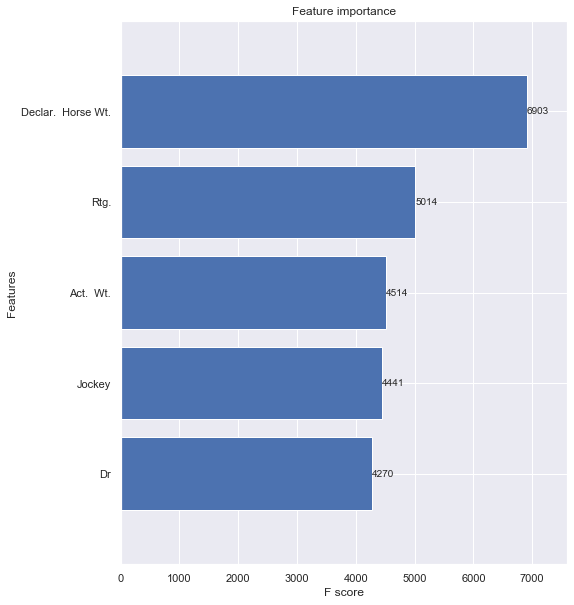

In [1420]:
clf = xgb.XGBClassifier(max_depth=11, n_estimators=300, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=.1, n_jobs = -1)
clf.fit(train, target)
# plot the important features #
fig, ax = plt.subplots(figsize=(8,10))
xgb.plot_importance(clf, max_num_features=5, height=0.8, ax=ax)
plt.show()

In [1421]:
scores = cross_val_score(clf, train, target, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.7422835085329557 +/- 0.03920215107617607
